# Sine Wave Example

For an interactive version of this example, see this [Observable notebook](https://observablehq.com/@dkirkby/boed).

This notebook performs similar calculations but with some important differences:
 - It is python code, not javascript, so significantly faster.
 - It uses the general-purpose [bayesdesign](https://pypi.org/project/bayesdesign) package,
   while the Observable notebook is hardcoded for this sine wave example.
 - It supports multi-dimensional grids for the parameters, features and designs, limited only by the available memory.

 To install the latest version of the [bayesdesign](https://pypi.org/project/bayesdesign) package, use:
 ```
 pip install bayesdesign
 ```
 Note that the python module included with this package uses the shorter name `bed` (for Bayesian Experiment Design).

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from bed.grid import Grid, GridStack
from bed.design import ExperimentDesigner

Define the experimental design space. A "design" in this problem consists of a choice of observation time $t_\text{obs}$.

In [3]:
designs = Grid(t_obs=np.linspace(0, 5, 51))

Define the data features. The data consists of a measurement $y_\text{obs}$ at $t_\text{obs}$.

In [4]:
features = Grid(y_obs=np.linspace(-1.25, 1.25, 100))

Define the parameters:
 - amplitude $A$
 - frequency $\omega$
 - offset $t_0$

for the model $y(t) = A \sin\left[ \omega (t - t_0) \right]$. In this example, only the frequency is unknown.

In [5]:
params = Grid(amplitude=1, frequency=np.linspace(0.2, 2.0, 181), offset=0)

Tabulate the likelihood $P(y_\text{obs}\mid A, \omega, t_0, t_\text{obs})$ for all possible designs $t_\text{obs}$. We assume a Gaussian distribution of measurements with mean $y(t)$ and fixed standard deviation $\sigma_y$.

In [6]:
sigma_y=0.1
with GridStack(features, designs, params):
    y_mean = params.amplitude * np.sin(params.frequency * (designs.t_obs - params.offset))
    y_diff = features.y_obs - y_mean
    likelihood = np.exp(-0.5 * (y_diff / sigma_y) ** 2)
    features.normalize(likelihood)

The likelihood is a large array whose size limits how big a problem we can tackle in practice. It is indexed over the parameters, features, and designs.

Tabulate the prior $P(A,\omega,t_0)$ which we take to be flat:

In [7]:
prior = np.ones(params.shape)
params.normalize(prior);

Initialize an `ExperimentDesigner` to calculate the EIG for this problem:

In [8]:
designer = ExperimentDesigner(params, features, designs, likelihood)

In [9]:
designer.calculateEIG(prior)
designer.describe()

GRID       designs [51:t_obs]
GRID      features [100:y_obs]
GRID    parameters [1:amplitude, 181:frequency, 1:offset]
ARRAY        prior (1, 181, 1)                0.0 Mb
ARRAY   likelihood (100, 51, 1, 181, 1)       7.0 Mb
ARRAY    posterior (100, 51, 1, 181, 1)       7.0 Mb
ARRAY     marginal (100, 51)                  0.0 Mb
ARRAY           IG (100, 51)                  0.0 Mb
ARRAY          EIG (51,)                      0.0 Mb


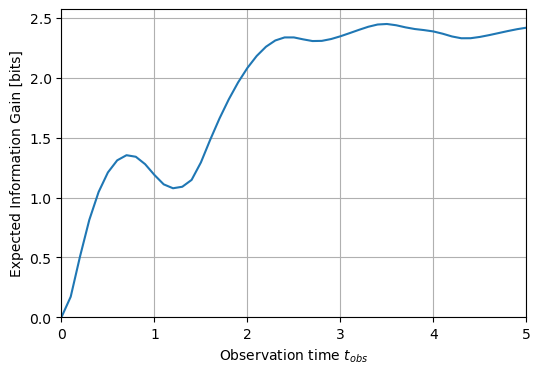

In [10]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(designs.t_obs, designer.EIG)
ax.set(xlabel='Observation time $t_{obs}$', xlim=designs.extent('t_obs'),
       ylabel='Expected Information Gain [bits]', ylim=(0, None))
ax.grid();